# Example Notebook #3 - ML Portfolio
This notebook illustrates asset selection using a user-specified statistical model. It allows the user to conduct prediction, rolling asset selection, and backtesting of the portfolio through the `MLPortfolio` and `PredictionModel` objects.

Suppose that given a window of returns $R_i$, we wish to model the asset pricing kernel through a set of features $\mathbf{X} \to \mathbb{R}$ through a flexible specification $R_i = f(\mathbf{X})$. We want to predict $R_i$ or $P(R_i > t), t \in \mathbf{R^1}$ for some threshold $t$ if specified as a binary classification problem. We can then treat the problem as that of mispricing by defining $R_i - \hat{R}_i$ as the differential which defines the magnitude of the mispricing predicted by the model. If treated as a classification problem, we can look at different measures such as predicted logit or probabilities in order to estimate ranks used for nonparametric construction of the portfolio.

For each period in the moving window, we perform the training episode across the section of the stocks and obtain the predictions. In this example notebook, we use a 5-year estimation period on monthly data points and a one month rebalancing window. All models are retrained in the estimation window, as well as optimized on a grid.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import talib
import seaborn as sns
from portfolio_swissknife import portfolio as ps
from portfolio_swissknife import models as mod

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

## 1. Load Data and Features
We use custom OHLCV of the main S&P 500 constituents adjusted for survivorship bias, macroeconomic and fundamental set of features in order to train the model. The macro data consist of features such as short-term lending rate, industrial production and others. Fundamental features are features collected from the financial reports of each of the firms. These features represent well established predictors in the asset pricing literature such as momentum, investment, liquidity, leverage, profitability, carry, and others. This dataset is, however, far from complete with regards to the available information set, and has been constructed for the purpose of this experiment. 

In [2]:
#load data
opn = pd.read_csv('../ext_data/00_db_SPX__PX_OPEN.csv',index_col=0, parse_dates=True)
opn.columns = opn.columns.map(lambda x:x.split(' ')[0])
opn = opn[::-1] #ascending dates
opn = opn.loc[:,~opn.columns.duplicated()]

high = pd.read_csv('../ext_data/00_db_SPX__PX_HIGH.csv',index_col=0, parse_dates=True)
high.columns = high.columns.map(lambda x:x.split(' ')[0])
high = high[::-1]
high = high.loc[:,~high.columns.duplicated()]

low = pd.read_csv('../ext_data/00_db_SPX__PX_LOW.csv',index_col=0, parse_dates=True)
low.columns = low.columns.map(lambda x:x.split(' ')[0])
low = low[::-1]
low = low.loc[:,~low.columns.duplicated()]


close = pd.read_csv('../ext_data/00_db_SPX__PX_LAST.csv',index_col=0, parse_dates=True)
close.columns = close.columns.map(lambda x:x.split(' ')[0])
close = close[::-1] 
close = close.loc[:,~close.columns.duplicated()]

volume = pd.read_csv('../ext_data/00_db_SPX__PX_VOLUME.csv',index_col=0, parse_dates=True)
volume.columns = volume.columns.map(lambda x:x.split(' ')[0])
volume = volume[::-1]
volume = volume.loc[:,~volume.columns.duplicated()]

macro = pd.read_excel('../ext_data/macro.xlsx',sheet_name = 'data', index_col = 0, parse_dates = True)
macro = macro.loc[close['AAPL'].index[0]:close['AAPL'].index[-1]] #reindex

with open('../ext_data/features.pkl', 'rb') as handle:
    fund = pickle.load(handle)

In [3]:
#loading ext. data -- close prices of SPX
universe = pd.read_csv('../ext_data/00_db_SPX__PX_LAST.csv', index_col = 0, parse_dates = True)
universe = universe[::-1].loc[:,universe.notna().all(axis=0)]
securities = [universe.columns[i].split(' ')[0] for i, _ in enumerate(universe.columns)]
universe.columns = securities
missing = ['BF/B','BRK/B','CXO','ETN','LB','VAR','UAL']
universe = universe.drop(missing, axis = 1)
securities = [elem for elem in securities if elem not in missing]

## 2. Constructing ML Portfolio based on Random Forest Classifier

### 2a. Create Portfolio universe and Prediction Model objects
We start by creating the `Portfolio` for the universe we will be training on. Then we create the `PredictionModel` object with the universe and add features to the model. The model takes care of aligining the dates and dataset processing in the backend, which allows the user to input data on different frequencies. For example, by adding macro features first, the fundamental features are merged left so that the resulting dataset is on a monthly granularity. Calling the method `prepare_targets` takes care of the target returns and aligns the indices with the prespecified dataset.

In [4]:
port_universe = ps.Portfolio(securities)
port_universe.set_custom_prices(universe, 'daily')

In [5]:
pred_model = mod.PredictionModel(port_universe)
pred_model.set_features(macro.to_period('M')) #add macro features
pred_model.set_features({sec : fund[sec].to_period('M') for 
                         sec in fund.keys()}) #add fundamental features
pred_model.prepare_targets(macro)

### 2b. Define a Training Episode

We define a training episode as a function that takes in a continuous target y, and set of features X. This function is used for the rolling training conducted later. The function defines the whole procedure of fitting the model and predicting the measure $f(X) \to \mathbb{R^1}$ that is used for portfolio construction. In this case, the RandomForest is optimized on a discrete grid and fit with prediction probabilities to be used for forming the portfolio and returned by the function. After specifying this function we set the model using the `set_prediction_model` method.

In [6]:
def rf_training_episode(y, X):
    #labeling
    y = y.apply(lambda x: 1 if x >= 0.02 else 0)
    
    #grid search
    grid = {'n_estimators': [200, 500], 'max_depth': [3, 9, 12],
            'max_features': [4, 8, 12], 'random_state': [42]}
    test_scores = []

    rf_model = RandomForestClassifier()

    for g in ParameterGrid(grid):
        rf_model.set_params(**g) 
        rf_model.fit(X, y)
        test_scores.append(rf_model.score(X, y))

    best_index = np.argmax(test_scores)
    
    #fitting the optimal model
    rf = RandomForestClassifier(**ParameterGrid(grid)[best_index])
    rf.fit(X, y)
    
    pred_prob_long = rf.predict_proba(X)[-1][1]
    return pred_prob_long

In [7]:
pred_model.set_prediction_model(rf_training_episode)

### 2c. Train the model using a rolling window

The model is then trained using `rolling_model_prediction`. Results are saved and can be loaded by using the `load_pretrained_model` function. This is also the case in this example as the model prediction took a lot of time.

In [8]:
# pred_model.rolling_model_prediction(estimation_period=60, window = 1)

In [9]:
# ## save intermediate results
# with open('tree_preds_2.pkl', 'wb') as handle:
#     pickle.dump(pred_model.prediction_measure, handle, protocol= pickle.HIGHEST_PROTOCOL)

In [10]:
with open('tree_preds_1.pkl', 'rb') as handle:
    preds_1 = pickle.load(handle)
with open('tree_preds_2.pkl', 'rb') as handle:
    preds_2 = pickle.load(handle)

In [11]:
pred_model.load_pretrained_model([preds_1, preds_2])

### 2d. Conduct asset selection by sorting 
Calling the `rolling_spread_selection` will select the assets based on the specified percentile.

In [12]:
pred_model.rolling_spread_selection(percentile = 10, window = 1)

### 2e. Initialize ML Portfolio and backtest the strategy
An `MLPortfolio` class is instantiated with the universe and prediction model we would like to use. All the backtesting methods are then provided similar to the parent `Portfolio` class.

In [13]:
ml_portfolio_trees = ps.MLPortfolio(port_universe, prediction_model = pred_model)
ml_portfolio_trees.set_constraints(default = True)
ml_portfolio_trees.set_benchmark('SPY')
ml_portfolio_trees.set_discount('^TNX')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### 2e i. Long only Random Forest Portfolio

In [20]:
ml_portfolio_trees.historical_backtest(long_only = True, long_exposure = 1,
                                       models = ['EW', 'GMV', 'RP', 'MDD'],
                                       frequency = 22, estimation_period = 5*252)

C:\Users\matus\anaconda3\envs\pf_dev\lib\site-packages\portfolio_swissknife\metrics.py:193: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt((nu_fit - 2) / nu_fit) * t.ppf(1 - alpha, nu_fit) * sig_fit_norm - mu_fit_norm


,EW,GMV,RP,MDD
Average Returns,15.38%,9.39%,13.73%,15.73%
CAGR,14.62%,8.41%,13.14%,14.86%
Volatility,39.21%,30.65%,37.05%,39.66%
CEQ,-4.229115,-5.931695,-4.797951,-164.827697
Max DD,41.96%,39.50%,37.47%,28.16%
Skewness,-0.97,-0.55,-0.76,-0.13
Kurtosis,-2.99,-2.99,-2.99,-2.99
Sharpe Ratio,0.34,0.24,0.31,0.34
Sortino Ratio,0.80,0.52,0.79,0.87
Calmar Ratio,-0.37,-0.24,-0.37,-0.56


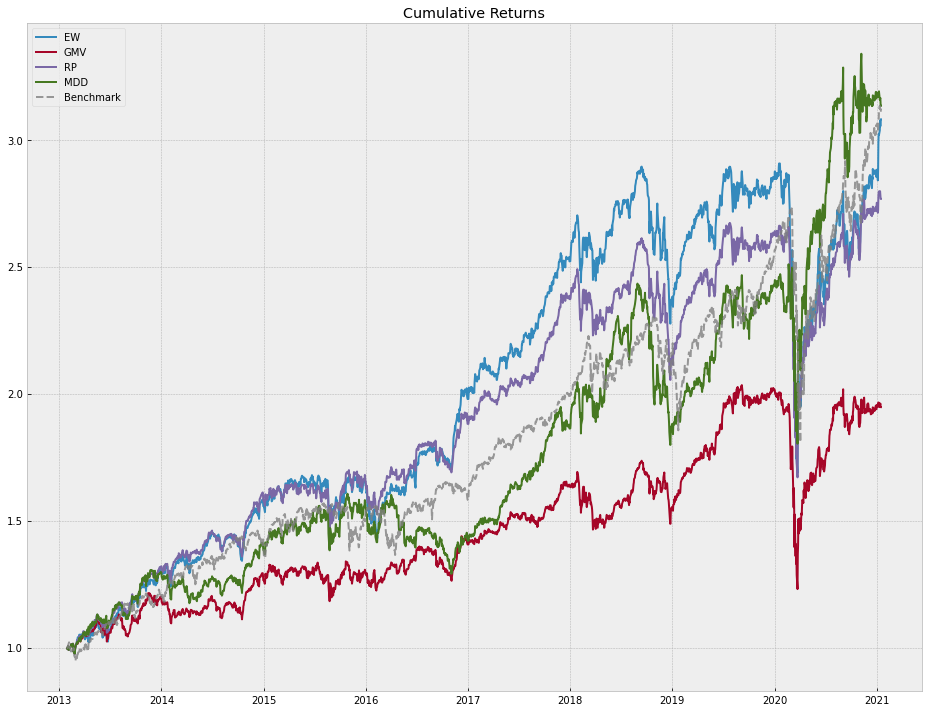

In [21]:
ml_portfolio_trees.get_backtest_report(display_weights=False, num_periods = 252)

#### 2e ii. Long short 130 30 Random Forest Portfolio

In [22]:
ml_portfolio_trees.historical_backtest(long_only = False, long_exposure = 1.3, 
                                       short_exposure = 0.3,
                                       models = ['EW', 'GMV', 'RP', 'MDD'],
                                       frequency = 22, estimation_period = 5*252)


,EW,GMV,RP,MDD
Average Returns,16.55%,8.77%,14.41%,17.01%
CAGR,15.73%,7.54%,13.77%,15.72%
Volatility,40.68%,29.62%,37.95%,41.24%
CEQ,-3.788801,-6.037352,-4.570872,-3.608888
Max DD,44.81%,42.50%,39.19%,27.57%
Skewness,-0.83,-0.39,-0.59,-0.12
Kurtosis,-2.99,-2.99,-2.99,-3.00
Sharpe Ratio,0.35,0.22,0.32,0.36
Sortino Ratio,0.84,0.46,0.82,0.85
Calmar Ratio,-0.37,-0.21,-0.37,-0.62


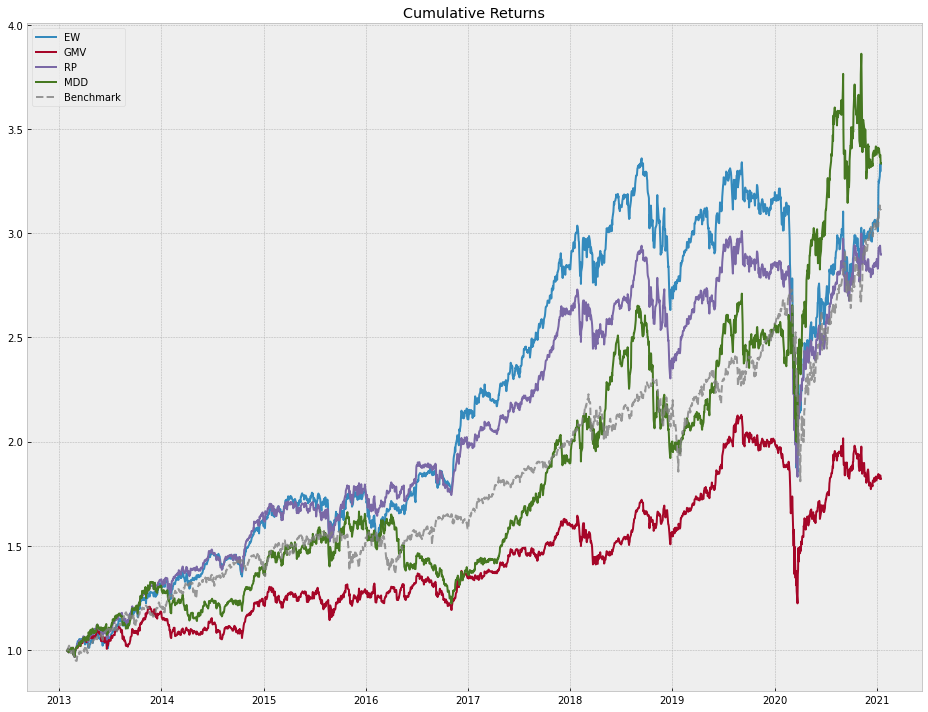

In [23]:
ml_portfolio_trees.get_backtest_report(display_weights=False, num_periods = 252)

## 3. Constructing MLPortfolio based on XGBoost Classifier

In [93]:
def xgb_training_episode(y, X):
    y = y.apply(lambda x: 1 if x >= 0 else 0)
    
    xg_mod = XGBClassifier(eval_metric = 'mlogloss',
                           use_label_encoder=False)
    xg_mod.fit(X, y)
    
    pred_prob_long = xg_mod.predict_proba(X)[-1][1]
    
    return pred_prob_long
    

In [94]:
pred_modelx = mod.PredictionModel(port_universe)
pred_modelx.set_features(macro.to_period('M')) #add macro features
pred_modelx.set_features({sec : fund[sec].to_period('M') for 
                         sec in fund.keys()}) #add fundamental features
pred_modelx.prepare_targets(macro)

In [95]:
pred_modelx.set_prediction_model(xgb_training_episode)

In [96]:
# pred_modelx.rolling_model_prediction(estimation_period=60, window = 1)
with open('xgboost_preds.pkl', 'rb') as handle:
    preds_xg = pickle.load(handle)
pred_modelx.load_pretrained_model(preds_xg)

In [97]:
pred_modelx.rolling_spread_selection(percentile = 10, window = 1)

In [98]:
# ## save results
# with open('xgboost_preds.pkl', 'wb') as handle:
#     pickle.dump(pred_model.prediction_measure, handle, protocol= pickle.HIGHEST_PROTOCOL)

In [99]:
ml_portfolio_xg = ps.MLPortfolio(port_universe, prediction_model = pred_modelx)
ml_portfolio_xg.set_constraints(default = True)
ml_portfolio_xg.set_benchmark('SPY')
ml_portfolio_xg.set_discount('^TNX')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [100]:
ml_portfolio_xg.historical_backtest(long_only = False, long_exposure = 1, short_exposure= 0.3,
                                       models = ['EW', 'GMV', 'RP', 'MDD'],
                                       frequency = 22, estimation_period = 5*252)

,EW,GMV,RP,MDD
Average Returns,11.65%,8.73%,9.94%,12.95%
CAGR,11.40%,8.38%,9.67%,12.55%
Volatility,34.13%,29.55%,31.52%,35.98%
CEQ,-5.417055,-6.044122,-5.825188,-5.043752
Max DD,27.54%,20.88%,24.60%,20.44%
Skewness,-0.31,-0.22,-0.62,-0.42
Kurtosis,-3.00,-3.00,-3.00,-3.00
Sharpe Ratio,0.28,0.22,0.25,0.30
Sortino Ratio,0.88,0.73,0.78,0.89
Calmar Ratio,-0.42,-0.42,-0.40,-0.63


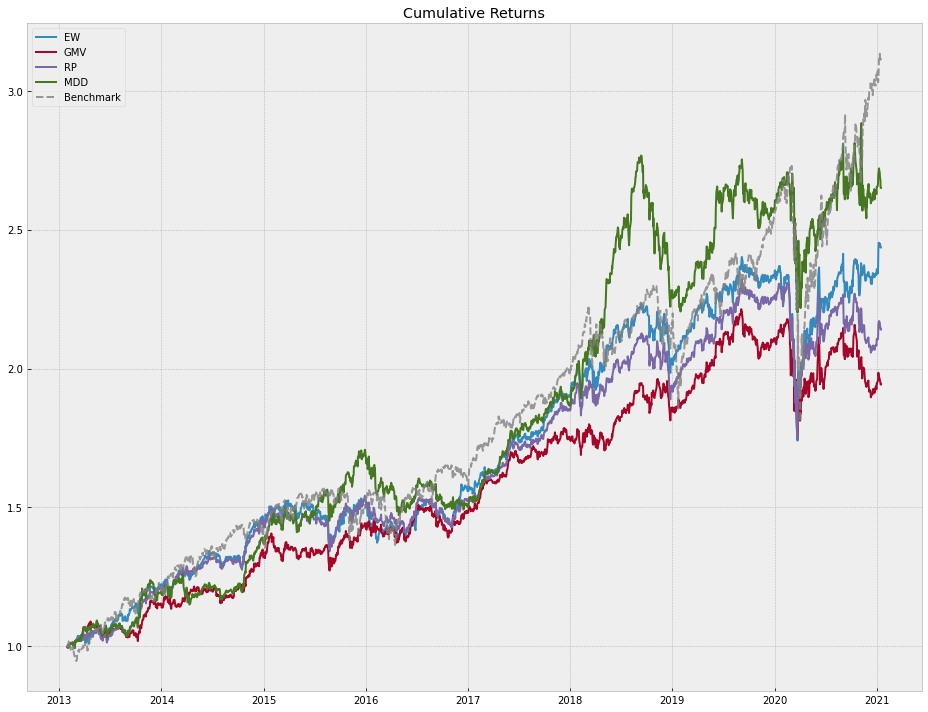

In [101]:
ml_portfolio_xg.get_backtest_report(display_weights=False, num_periods = 252)